In [11]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from matplotlib import pyplot as plt
from skimage import io, transform
import math
from math import sqrt
import numpy as np
import numpy
import os
from os import listdir
import cv2
from numpy.random import normal
from numpy.linalg import svd
import time

In [12]:
torch.cuda.set_device(1)

In [3]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from skimage import io, transform

class Vgg16(torch.nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

    def forward(self, X):
        h = F.relu(self.conv1_1(X))
        h = F.relu(self.conv1_2(h))
        relu1_2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv2_1(h))
        h = F.relu(self.conv2_2(h))
        relu2_2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv3_1(h))
        h = F.relu(self.conv3_2(h))
        h = F.relu(self.conv3_3(h))
        relu3_3 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv4_1(h))
        h = F.relu(self.conv4_2(h))
        h = F.relu(self.conv4_3(h))
        relu4_3 = h

        return [relu1_2, relu2_2, relu3_3, relu4_3]

class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        self.model = Vgg16().eval().cuda()
        
    def tot_size(self, x):
        tot = 1.0
        for i in x:
            tot += i
        return tot
    
    def features(self, x):
        return self.model.forward(x)
    
    def forward(self, x, y):
        feat_x = self.model.forward(x)
        feat_y = self.model.forward(y)
        feat_mse_sum = 0.0
        total_pixels = 0.0
        for i in range(len(feat_x)):
            feat_mse_sum += torch.sum((feat_x[i] - feat_y[i])**2)
            total_pixels += self.tot_size(feat_x[i].size())
        return feat_mse_sum/total_pixels
        
class HuberLoss(nn.Module):
    def __init__(self):
        super(HuberLoss, self).__init__()
    
    def _huber_loss(x, y):
        res = torch.sqrt((x-y)**2 + 1e-8)
        n_elements = res.numel()
        return torch.sum(res)/n_elements

    def forward(self, x, y):
        return HuberLoss._huber_loss(x, y)

In [14]:
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(inplanes, planes, 3, stride, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        #self.downsample = downsample
        #self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        #if self.downsample is not None:
        #    residual = self.downsample(x)

        out += residual


        return out


In [15]:
def _get_orthogonal_init_weights(weights):
    fan_out = weights.size(0)
    fan_in = weights.size(1) * weights.size(2) * weights.size(3)

    u, _, v = svd(normal(0.0, 1.0, (fan_out, fan_in)), full_matrices=False)

    if u.shape == (fan_out, fan_in):
        return torch.Tensor(u.reshape(weights.size()))
    else:
        return torch.Tensor(v.reshape(weights.size()))

    
class ResNet(nn.Module):
    def __init__(self):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.prelu1 = nn.PReLU()
        
        self.layer1 = BasicBlock(64, 64)
        self.layer2 = BasicBlock(64, 64)
        self.layer3 = BasicBlock(64, 64)
        self.layer4 = BasicBlock(64, 64)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.shuffle1 = nn.PixelShuffle(2)
        self.prelu2 = nn.PReLU()
        
        self.conv4 = nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.shuffle2 = nn.PixelShuffle(2)
        self.prelu3 = nn.PReLU()
        
        self.conv5 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.copy_(_get_orthogonal_init_weights(m.weight) * sqrt(2))
                m.weight.data.copy_(_get_orthogonal_init_weights(m.weight) * sqrt(2))
                m.weight.data.copy_(_get_orthogonal_init_weights(m.weight) * sqrt(2))
                m.weight.data.copy_(_get_orthogonal_init_weights(m.weight))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        

    def forward(self, x):
        out = x
        out = self.conv1(out)
        out = self.prelu1(out)
        residual = out

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += residual
        
        out = self.conv3(out)

        out = self.shuffle1(out)
        out = self.prelu2(out)
        
        out = self.conv4(out)
        out = self.shuffle2(out)
        out = self.prelu3(out)
        
        out = self.conv5(out)

        return out
    


In [16]:
generator = torch.load("/home/b.lestsov/models/vgg80k.pt")

In [19]:
dir_name = "/home/b.lestsov/datasets/test/super-res-test-div4/"
out_dir = "/home/b.lestsov/out/"
#images = os.listdir(dir_name)
#i = 125
images = ['20140614_230008.jpg', '20140614_230122.jpg', '20140913_162645_Pano.jpg']
for img in images:
    path = dir_name+img
    print(path)
    inp = cv2.imread(path)
    #inp = cv2.cvtColor(inp, cv2.COLOR_BGR2RGB)
    print(inp.shape)
    inp = cv2.resize(inp, None, 
                     fx=4.0, fy=4.0, 
                     interpolation=cv2.INTER_CUBIC)
    io.imsave(out_dir+img, inp)
    continue
    inp = inp / 256.0
    inp = numpy.clip(inp, 0.0, 1.0)
    
    
    
    inp = inp.swapaxes(1, 2).swapaxes(0, 1)
    inp = inp.reshape((1,) + inp.shape)
    inp = torch.Tensor(inp).cuda()
    inp = torch.autograd.Variable(inp, volatile=True)
    
    res = generator.forward(inp)
    io.imsave(out_dir+img, res[0].cpu().data.numpy().swapaxes(1, 0).swapaxes(2, 1).clip(0, 1))

/home/b.lestsov/datasets/test/super-res-test-div4/20140614_230008.jpg
(4888, 756, 3)
/home/b.lestsov/datasets/test/super-res-test-div4/20140614_230122.jpg
(4952, 688, 3)
/home/b.lestsov/datasets/test/super-res-test-div4/20140913_162645_Pano.jpg
(416, 2880, 3)


In [ ]:
def get_inp_targ(path, num_scales=1, fraction=8):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    x_cut = img.shape[0] % fraction
    y_cut = img.shape[1] % fraction
    
    img = img[x_cut:, y_cut:, :].astype(float)
    img = img / 256.0
    
#     print(img.max())
    
#     imshow(img)
    #targs = [img]
    targ = img
    
    scale_factor = 1.0
    for index in range(num_scales):
        scale_factor /= 2.0
        
    inp = cv2.resize(img, None, 
                      fx=scale_factor, fy=scale_factor, 
                      interpolation=cv2.INTER_CUBIC)
    
    targ = numpy.clip(targ, 0.0, 1.0)
    inp = numpy.clip(inp, 0.0, 1.0)
    #targs.append(targ)
        
    #inp = targ
    #targs = targs[:-1][::-1]
    
#     print(inp.max())
#     imshow(inp)
    
    inp = inp.swapaxes(1, 2).swapaxes(0, 1)
    inp = inp.reshape((1,) + inp.shape)
    inp = torch.Tensor(inp).cuda()
    inp = torch.autograd.Variable(inp)
    
    targ = targ.swapaxes(1, 2).swapaxes(0, 1)
    targ = targ.reshape((1,) + targ.shape)
    targ = torch.Tensor(targ).cuda()
    targ = torch.autograd.Variable(targ)
    
    #for targ_index in range(len(targs)):
    #    targs[targ_index] = torch.autograd.Variable(
    #        torch.Tensor(
    #            targs[targ_index].swapaxes(1, 2).swapaxes(0, 1)).cuda())
    
    return inp, targ

In [ ]:
optimizer = optim.Adam(generator.parameters(), lr=1e-4)
dir_name = "/home/m.romanov/super-resolution/train/"
images = os.listdir(dir_name)
step_index = 0
print(images[0])
#crit = nn.MSELoss()
#crit = HuberLoss(1e-8)
crit3 = HuberLoss()
crit2 = nn.MSELoss()
crit = VGGLoss()
i_last = 0;

In [ ]:
batch_size = 6
crop = 400

for epoch_index in range(5):
    last = 72500
    while last != len(images):
        print(last)
        inp_batch = torch.Tensor(batch_size, 3, crop//4, crop//4).cuda()
        targ_batch = torch.Tensor(batch_size, 3, crop, crop).cuda()
        i = 0
        while i != batch_size:
            img_path = dir_name + images[last]
            inp, targ = get_inp_targ(img_path, 2)
            last += 1
            while targ.size()[2] < crop or targ.size()[3] < crop:
                last += 1
                img_path = dir_name + images[last]
                inp, targ = get_inp_targ(img_path, 2)

            #targ = targ.unsqueeze(0)
            #inp = inp.unsqueeze(0)
            inp = inp[:, :, :crop//4, :crop//4]
            
            targ = targ[:, :, :crop, :crop]
            inp_batch[i] = inp.data
            targ_batch[i] = targ.data
            i += 1

        optimizer.zero_grad()

        res = generator.forward(Variable(inp_batch))

        loss = crit(res, Variable(targ_batch)) + 0.3*crit2(res, Variable(targ_batch)) + 0.3*crit3(res, Variable(targ_batch))
        loss.backward()

        optimizer.step()

        if step_index % 1 == 0:
            print(loss.data[0], end=' ')


In [7]:
#inp, targ = get_inp_targ("/home/b.lestsov/datasets/SelfExSR/data/BSD100/my/x2x_HR/img_004_SRF_2_HR.png", 1)
inp, targ = get_inp_targ("/home/b.lestsov/datasets/test/super-res-test-div2/2012-05-27 19.15.35.jpg", 0)
plt.figure(figsize=(10, 10))
res = generator.forward(inp)
io.imshow(res[0].cpu().data.numpy().swapaxes(1, 0).swapaxes(2, 1).clip(0, 1))

plt.show()

NameError: name 'get_inp_targ' is not defined

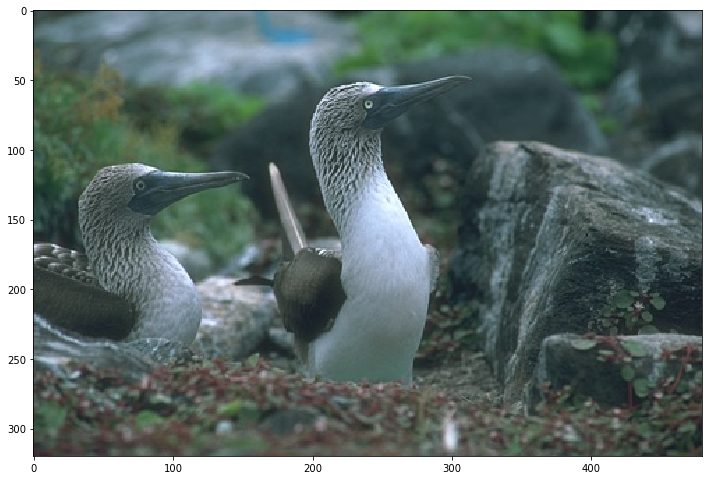

In [13]:
plt.figure(figsize=(10, 10))
io.imshow(targ[0].cpu().data.numpy().swapaxes(1, 0).swapaxes(2, 1).clip(0, 1))
plt.show()

In [105]:
io.imsave("/home/b.lestsov/pic/out.png", res[0].cpu().data.numpy().swapaxes(1, 0).swapaxes(2, 1).clip(0, 1))